In [11]:
import pandas as pd
import numpy as np
# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [2]:
df = pd.read_pickle('supermarket_4.pkl')

In [4]:
df.head()

,city,customer_type,gender,product_line,unit_price,quantity,date,time,payment,rating,...,product_line_Sports and travel,payment_Cash,payment_Credit card,payment_Ewallet,month_February,month_January,month_March,shift_Afternoon,shift_Morning,quantity_num
0,Yangon,Member,Female,Health and beauty,0.431869,7,2019-01-05,13:08,Ewallet,0.700000,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7
1,Naypyitaw,Normal,Female,Electronic accessories,-0.886596,5,2019-03-08,10:29,Cash,0.866667,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5
2,Yangon,Normal,Male,Home and lifestyle,-0.197514,7,2019-03-03,13:23,Credit card,0.133333,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,7
3,Yangon,Member,Male,Health and beauty,0.066356,8,2019-01-27,20:33,Ewallet,0.466667,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,8
4,Yangon,Normal,Male,Sports and travel,0.689747,7,2019-02-08,10:37,Ewallet,-0.566667,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,7


In [8]:
X = df.drop(["total_boxcox", "city", "customer_type", "gender", "product_line", "quantity", "date", "time", "payment", "month", "shift"], axis = 1)
y = df["total_boxcox"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

arbol = DecisionTreeRegressor(random_state =0)

arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

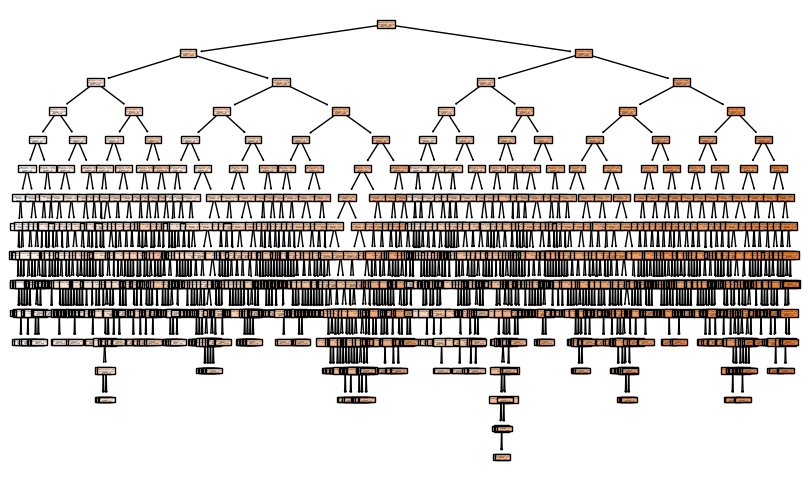

In [9]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train.columns.tolist(), filled = True)
plt.show()

In [12]:
max_features = np.sqrt(len(x_train.columns))
print(max_features)
print(arbol.tree_.max_depth)

4.898979485566356
15


In [13]:
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [16]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    """esta función nos devuelve un df con las métricas de un Decission Tree.

    Args:
        y_test (serie): datos con los que se testea el Decission Tree.
        y_train (serie): datos con los que aprende el Decission Tree.
        y_test_pred (array): valores predichos de testeo.
        y_train_pred (array): valores predichos de entrenamiento.
        tipo_modelo (string): nombre que le quieres dar al Decission Tree

    Returns:
        df: return con las métricas del df.
    """
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [17]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,0.143722,0.058091,0.24102,0.996639,test,Decission Tree I
1,0.000000,0.000000,0.00000,1.000000,train,Decission Tree I


CONCLUSIÓN:

- Existe overfitting puesto que al sacar las métricas los valores de R2 son 

In [18]:
# Creamos un diccionario con los hiperparámetros que queremos modificar.
param = {"max_depth": [2,4, 6], # bajamos la profundidad del modelo para intentar compensar el overfitting
        "max_features": [1,2,3,4],
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]}

In [19]:
gs = GridSearchCV(
        estimator=DecisionTreeRegressor(),
        param_grid= param, 
        cv=10, 
        verbose= 0,
        return_train_score = True,
        scoring="neg_mean_squared_error") 

In [20]:
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [21]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=6, max_features=4, min_samples_leaf=10,
                      min_samples_split=10)

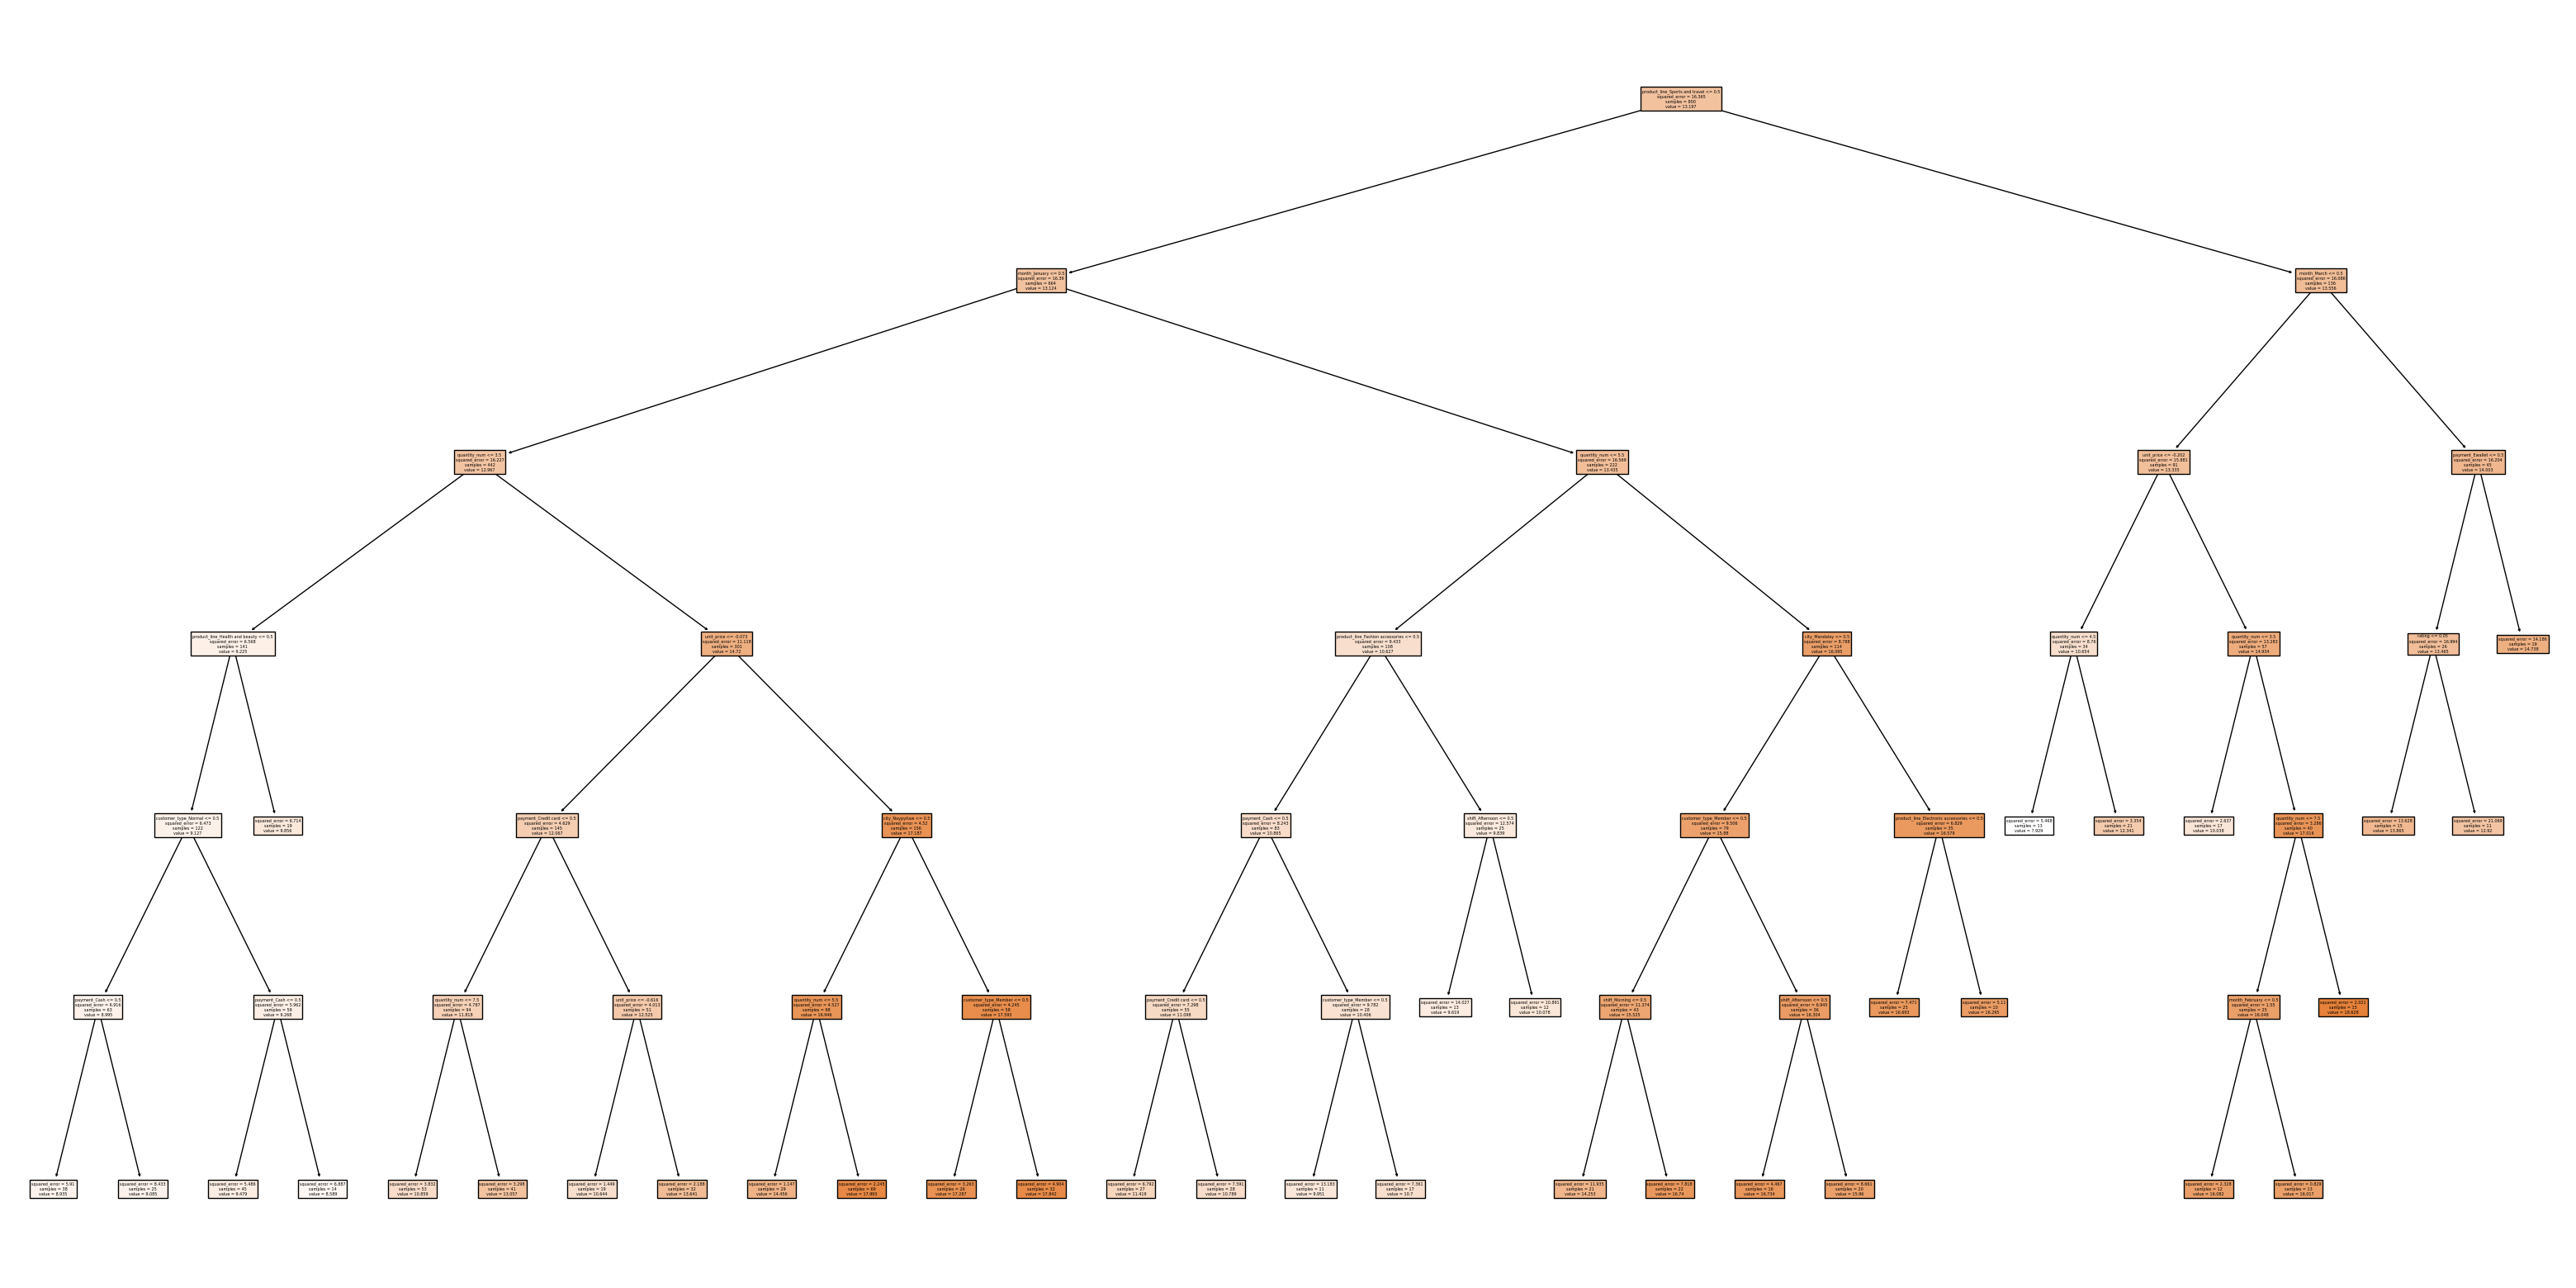

In [23]:
fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns.tolist(), filled=True);

In [24]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,2.117610,6.579472,2.565048,0.619304,test,Decision tree II
1,1.903967,5.771827,2.402463,0.647301,train,Decision tree II


In [ ]:
df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_linear_results = pd.read_csv("../data/resultados_supermarket.csv", index_col = 0)
df_linear_results